# Utils

In [1]:
#|default_exp utils

In [2]:
#| export
import numpy as np
import pandas as pd
import os
from fastcore.all import *
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from tsai.basics import SlidingWindow
from tsai.utils import yaml2dict, load_object
from tsai.data.external import download_data
from collections import Counter
from itertools import combinations, chain
import more_itertools as mit
from tqdm import tqdm
import requests
import papermill as pm


config = yaml2dict('../dev_nbs/config/solfsmy.yaml', attrdict=True)

In [3]:
#| export
def plot_forecast_2(X_true, y_true, y_pred, dtms=None, sel_vars=None, idx=None, figsize=(8, 4), n_samples=1):
    #TODO: add support for dynamic x axis interval in set_major_locator
    import matplotlib.pyplot as plt
    import matplotlib.patches as mpatches

    def _plot_forecast(X_true, y_true, y_pred, sel_var=None, idx=None, figsize=(8, 4)):
        if idx is None:
            idx = np.random.randint(0, len(X_true))
        if sel_var is None:
            title = f'sample: {idx}'
        else:
            title = f'sample: {idx} sel_var: {sel_var}'
        if sel_var is None: sel_var = slice(None)

        pred = np.concatenate([X_true[idx, sel_var], y_true[idx, sel_var]], -1)
        pred[..., :X_true.shape[-1]] = np.nan

        true = np.concatenate([X_true[idx, sel_var], y_pred[idx, sel_var]], -1)
        true_hist = true.copy()
        true_fut = true.copy()

        true_hist[..., X_true.shape[-1]:] = np.nan
        true_fut[..., :X_true.shape[-1]] = np.nan
                
        plt.figure(figsize=figsize)
        if dtms is not None:
            #dtms_plot = pd.to_datetime(dtms[idx])
            dtms_plot = mdates.date2num(dtms[idx])
            plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
            plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=10))
            plt.xlim(min(dtms_plot), max(dtms_plot))
            plt.plot(dtms_plot, pred.T, color='orange', lw=1, linestyle='--')
            plt.plot(dtms_plot, true_hist.T, color='purple', lw=1)
            plt.plot(dtms_plot, true_fut.T, color='purple', lw=1, linestyle='--')
            plt.axvline(dtms_plot[X_true.shape[-1]-1], color='gray', lw=.5, linestyle='--')
        else:
            plt.xlim(0, X_true.shape[-1] + y_true.shape[-1])
            plt.plot(pred.T, color='orange', lw=1, linestyle='--')
            plt.plot(true_hist.T, color='purple', lw=1)
            plt.plot(true_fut.T, color='purple', lw=1, linestyle='--')
            plt.axvline(X_true.shape[-1] - 1, color='gray', lw=.5, linestyle='--')

        plt.title(title)
        pred_patch = mpatches.Patch(color='orange', label='pred')
        true_patch = mpatches.Patch(color='purple', label='true')
        plt.legend(handles=[true_patch, pred_patch], loc='best')
        plt.show()
      
    assert X_true.shape[:-1] == y_true.shape[:-1] == y_pred.shape[:-1]
    assert y_true.shape[-1] == y_pred.shape[-1]
    
    if idx is not None:
        idx = listify(idx)
        n_samples = len(idx)
        iterator = idx
    else:
        iterator = random_randint(len(X_true), size=n_samples)
    
    if sel_vars is None:
        for idx in iterator:
            _plot_forecast(X_true, y_true, y_pred, sel_var=None, idx=idx, figsize=figsize)
    else:
        for idx in iterator:
            if sel_vars is True:
                sel_vars = np.arange(y_true.shape[1])
            else:
                sel_vars = listify(sel_vars)
            for sel_var in sel_vars:
                _plot_forecast(X_true, y_true, y_pred, sel_var=sel_var, idx=idx, figsize=figsize)


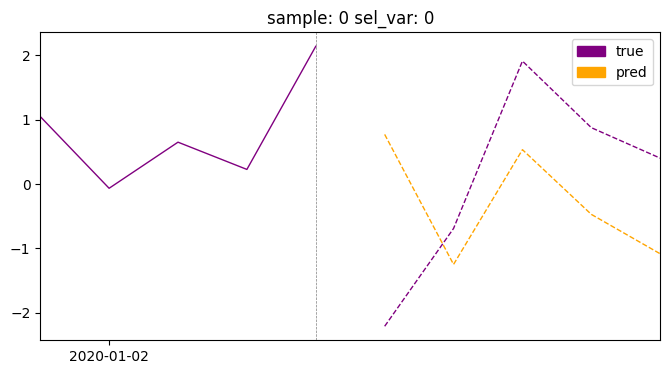

In [4]:
# Test
n_samples = 100
n_vars = 10
lookback = 5
horizon = 5
X_true = np.random.randn(n_samples, n_vars, lookback)
y_true = np.random.randn(n_samples, n_vars, horizon)
y_pred = np.random.randn(n_samples, n_vars, horizon)
# dtms must be a 2D numpy array of datetime objects with the shape 
# (n_samples x (lookback + horizon))
dtms = np.array([pd.date_range('2020-01-01', 
                               periods=lookback + horizon, 
                               freq='D') for i in range(n_samples)])
plot_forecast_2(X_true, y_true, y_pred, dtms=dtms, sel_vars=0, idx=0, 
                figsize=(8, 4), n_samples=1)

In [5]:
#|export

def plot_solar_algorithm_performance(df, var, figsize=(10, 10), ylims=None):
    # Plot a grid where each row is a solar activity level, and each column
    # is a error type (sfu or percent). Each cell is the result of calling the 
    # function plot_fe.
    # Input:
    # df: dataframe with the results of the forecasting experiment, with the columns
    #     variable, condition, horizon, mean_sfu, std_sfu, mean_percent, std_percent
    # var: variable to plot (F10, S10, M10, Y10)
    # figsize: figure size
    # ylims_mean: List with the y limits of the mean for each error type: 
    #   [(percent[0], percent[1]), (sfu[0], sfu[1])]
    # ylims_std: List with the y limits of the standard deviation for each error type:
    #   [(percent[0], percent[1]), (sfu[0], sfu[1])]
    # Output:
    # None, but it plots the grid
    sals = ['low', 'moderate', 'elevated', 'high']
    fig, axs = plt.subplots(len(sals), 2, figsize=figsize)
    fig.suptitle(f"Forecast error for {var}")
    for sal_idx, sal in enumerate(sals):
        for idx, err_type in enumerate(['percent', 'sfu']):
            df_var = df[(df['variable'] == var) & (df['condition'] == sal)]
            # Minimum and maximum values across column
            min_val = df[f'mean_{err_type}'].min() - np.abs(df[f'std_{err_type}'].max()) if ylims is None else ylims[idx][0]
            max_val = df[f'mean_{err_type}'].max() + np.abs(df[f'std_{err_type}'].max()) if ylims is None else ylims[idx][1]


            mean_fe = df_var[f'mean_{err_type}'].values
            std_fe = df_var[f'std_{err_type}'].values
            ax = axs[sal_idx, idx]
            p1 = ax.plot(mean_fe, color='#000000', label='Mean')
            ax.set_xlabel('Days from Epoch')
            ax.set_ylabel(f'Mean [{err_type}]', color='#000000')
            ax.tick_params(axis='y', labelcolor='#000000')
            ax.set_xticks(range(len(mean_fe)))
            ax.set_xticklabels(range(1, len(mean_fe)+1))
            ax.set_ylim(min_val, max_val)
            ax.set_yticks(np.arange(-20, 21, 5))
            ax.fill_between(range(len(mean_fe)), mean_fe - np.abs(std_fe), mean_fe + np.abs(std_fe), color='red', alpha=0.2)

            p2 = ax.fill(np.NaN, np.NaN, 'red', alpha=0.5)
            ax.legend([p1[0], p2[0]], ['Mean Error', '[STDE]'], loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=2, fancybox=True, shadow=True)
            
            n_samples = df_var['n_samples'].values[0] 
            ax.set_title(f'{sal}\n{n_samples} forecasts', pad=15)
            # Draw a grid in the background
            ax.grid(True, which='both', axis='both', color='lightgrey',
                    linestyle='-', linewidth=0.5)
            fig.tight_layout()

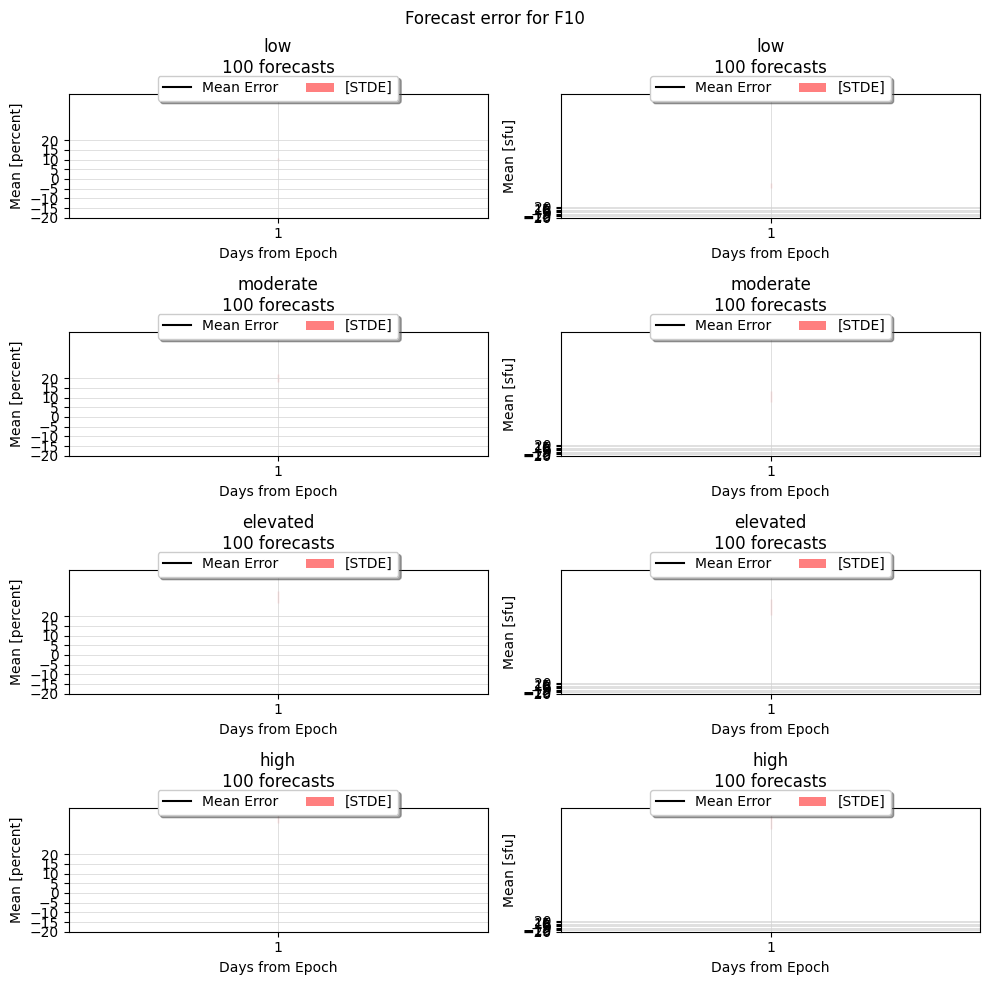

In [6]:
# Test 
df = pd.DataFrame({'variable': ['F10', 'F10', 'F10', 'F10', 'S10', 'S10', 'S10', 'S10'],
                   'condition': ['low', 'moderate', 'elevated', 'high', 'low', 'moderate', 'elevated', 'high'],
                   'horizon': [1, 1, 1, 1, 1, 1, 1, 1],
                   'n_samples': [100, 100, 100, 100, 100, 100, 100, 100],
                   'mean_percent': [10, 20, 30, 40, 10, 20, 30, 40],
                   'std_percent': [1, 2, 3, 4, 1, 2, 3, 4],
                   'mean_sfu': [100, 200, 300, 400, 100, 200, 300, 400],
                   'std_sfu': [10, 20, 30, 40, 10, 20, 30, 40]})
plot_solar_algorithm_performance(df, 'F10', figsize=(10, 10))

In [7]:
#|export
def plot_solar_algorithm_performance_comparison(df, df_paper, var, figsize=(10, 10), ylims=None):
    """
    Plots and compares forecast error metrics from two datasets for a given variable across different solar activity levels.

    Parameters:
    - df (DataFrame): Main dataset containing error metrics and sample counts.
    - df_paper (DataFrame): Benchmark dataset for comparison.
    - var (str): Variable of interest (e.g., temperature).
    - figsize (tuple): Dimensions of the figure (width, height).
    - ylims (list of tuples): Optional y-axis limits for each plot; defaults to auto-calculated based on data.

    This function creates a grid of subplots for each solar activity level, comparing two error types. 
    It adjusts y-limits, annotates subplots with sample sizes, and adds a legend and grid for clarity.
    """

    sals = ['low', 'moderate', 'elevated', 'high']
    fig, axs = plt.subplots(len(sals), 2, figsize=figsize)
    fig.suptitle(f"Forecast error for {var}")
    for sal_idx, sal in enumerate(sals):
        for idx, err_type in enumerate(['percent','sfu']):
            df_var = df[(df['variable'] == var) & (df['condition'] == sal)]
            df_paper_var = df_paper[(df_paper['variable'] == var) & (df_paper['condition'] == sal)]

            # Minimum and maximum values across column
            min_val = df_var[f'mean_{err_type}'].min() - np.abs(df_var[f'std_{err_type}'].max()) if ylims is None else ylims[idx][0]
            max_val = df_var[f'mean_{err_type}'].max() + np.abs(df_var[f'std_{err_type}'].max()) if ylims is None else ylims[idx][1]
            
            min_val_paper = df_paper_var[f'mean_percent'].min() - np.abs(df_paper_var[f'std_percent'].max()) if ylims is None else ylims[idx][0]
            max_val_paper = df_paper_var[f'mean_percent'].max() + np.abs(df_paper_var[f'std_percent'].max()) if ylims is None else ylims[idx][1]
            
            if np.isnan(min_val) or np.isnan(max_val):
                min_val = min_val_paper
                max_val = max_val_paper
            
            min_val = min(min_val, min_val_paper)
            min_val = int(min_val) - (int(min_val)%10)
            max_val = max(max_val, max_val_paper)
            max_val = int(max_val) + (10 - int(max_val)%10)

            mean_fe = df_var[f'mean_{err_type}'].values
            mean_fe_paper = df_paper_var[f'mean_{err_type}'].values
            std_fe = df_var[f'std_{err_type}'].values
            std_fe_paper = df_paper_var[f'std_{err_type}'].values 
            ax = axs[sal_idx, idx]
            p1 = ax.plot(mean_fe, color='#c00000')
            p3 = ax.plot(mean_fe_paper, color='#572364')

            ax.set_xlabel('Days from Epoch')
            ax.set_ylabel(f'Mean [{err_type}]', color='#000000')

            ax.tick_params(axis='y', labelcolor='#000000')
            ax.set_xticks(range(len(mean_fe)))
            ax.set_xticklabels(range(1, len(mean_fe)+1))
            ax.set_ylim(min_val, max_val)
            steps = (max_val-min_val)/10
            ax.set_yticks(np.arange(min_val, max_val,steps))
            ax.fill_between(range(len(mean_fe)), mean_fe - np.abs(std_fe),
                            mean_fe + np.abs(std_fe),
                            color='#ff8000', alpha=0.3)

            ax.fill_between(range(len(mean_fe_paper)), mean_fe_paper - np.abs(std_fe_paper),
                            mean_fe_paper + np.abs(std_fe_paper),
                            color='#9a2edb', alpha=0.2)

            
            p2 = ax.fill(np.NaN, np.NaN, '#ff8000', alpha=0.3)
            p4 = ax.fill(np.NaN, np.NaN, '#9a2edb', alpha=0.2)

            ax.legend([(p1[0], p2[0]),(p3[0], p4[0])],
                        ['Mean Error[STDE]', 'Mean Error (Benchmark) [STDE]'], 
                        loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=2, 
                        fancybox=True, shadow=True)

            
            n_samples = df_var['n_samples'].values[0] 
            ax.set_title(f'{sal}\n{n_samples} forecasts', pad=15)
            # Draw a grid in the background
            ax.grid(True, which='both', axis='both', color='lightgrey',
                    linestyle='-', linewidth=0.5)
            fig.tight_layout()

In [8]:
#| export
def plot_solar_algorithm_performance_all_indices(df, df_paper, figsize=(40, 15), ylims=None, save_fig=False):
    # Plot a grid where each row is a solar activity level, and each column is a variable.
    # Each cell contains the percent error comparison.
    # Input:
    # df: DataFrame with the results of the forecasting experiment, with the columns
    #     variable, condition, horizon, mean_percent, std_percent
    # df_paper: DataFrame with the results from the paper for comparison
    # figsize: figure size
    # ylims: List with the y limits for percent error: [(percent_min, percent_max)]
    # Output: None, but it plots the grid
    
    sals = ['low', 'moderate', 'elevated', 'high']
    vars = ['F10', 'S10', 'M10', 'Y10']
    
    fig, axs = plt.subplots(len(sals), len(vars), figsize=figsize)
    
    for sal_idx, sal in enumerate(sals):
        for var_idx, var in enumerate(vars):
            df_var = df[(df['variable'] == var) & (df['condition'] == sal)]
            df_paper_var = df_paper[(df_paper['variable'] == var) & (df_paper['condition'] == sal)]

            # Determine min and max values for y-axis
            min_val = df_var['mean_percent'].min() - np.abs(df_var['std_percent'].max()) if ylims is None else ylims[0][0]
            max_val = df_var['mean_percent'].max() + np.abs(df_var['std_percent'].max()) if ylims is None else ylims[0][1]
            
            min_val_paper = df_paper_var['mean_percent'].min() - np.abs(df_paper_var['std_percent'].max()) if ylims is None else ylims[0][0]
            max_val_paper = df_paper_var['mean_percent'].max() + np.abs(df_paper_var['std_percent'].max()) if ylims is None else ylims[0][1]
            
            min_val = min(min_val, min_val_paper)
            min_val = int(min_val) - (int(min_val)%10)
            max_val = max(max_val, max_val_paper)
            max_val = int(max_val) + (10 - int(max_val)%10)

            mean_fe = df_var['mean_percent'].values
            mean_fe_paper = df_paper_var['mean_percent'].values
            std_fe = df_var['std_percent'].values
            std_fe_paper = df_paper_var['std_percent'].values 
            
            ax = axs[sal_idx, var_idx]
            p1, = ax.plot(mean_fe, color='#c00000', lw=2.7)
            p2, = ax.plot(mean_fe_paper, color='#572364', lw=2.7)

            if sal_idx == len(sals) - 1:
                ax.set_xlabel('Days from Epoch', fontsize=18)
            if var_idx == 0:
                ax.set_ylabel(f'Error [%]', color='#000000', fontsize=18)

            ax.tick_params(axis='y', labelcolor='#000000')
            ax.set_xticks(range(len(mean_fe)))
            ax.set_xticklabels(range(1, len(mean_fe)+1), fontsize=14)
            ax.set_ylim(min_val, max_val)
            steps = (max_val - min_val) / 10
            ax.set_yticks(np.arange(min_val, max_val, steps))
            ax.set_yticklabels(np.arange(min_val, max_val, steps), fontsize=14)
            p3 = ax.fill_between(range(len(mean_fe)), mean_fe - np.abs(std_fe),
                            mean_fe + np.abs(std_fe),
                            color='#ff8000', alpha=0.3)

            p4 = ax.fill_between(range(len(mean_fe_paper)), mean_fe_paper - np.abs(std_fe_paper),
                            mean_fe_paper + np.abs(std_fe_paper),
                            color='#9a2edb', alpha=0.2)

            n_samples = df_var['n_samples'].values[0] 
            if sal_idx == 0:
                ax.set_title(f'{var}.7' , fontweight='bold', fontsize=26, pad=35)
       
            ax.text(0, max_val - steps, f'{n_samples} forecasts', fontsize=12, fontstyle='italic')
            ax.text(2.5, max_val + 1, f'{sal.capitalize()} Solar Activity', fontsize=20, fontstyle='italic', ha='center', )



            # Draw a grid in the background
            ax.grid(True, which='both', axis='both', color='lightgrey',
                    linestyle='-', linewidth=0.5)

    # Create a single legend at the bottom
    example_mean = ax.plot([], [], color='grey', lw=2.5, label='Mean')[0]
    example_std = ax.fill_between([], [], [], color='grey', alpha=0.3)

    # Combine handles and labels
    handles_example = [example_mean, example_std]
    labels_example = ['Mean', 'STD']
    measures_legend = fig.legend(handles_example, labels_example, 
                                loc='upper center', ncol=1, 
                                fancybox=True, shadow=True, fontsize=18, 
                                bbox_to_anchor=(0.47, 0.06), title='Measures'
                                )
    measures_legend.get_title().set_fontsize('14')

    handles = [(p1, p3), (p2, p4)]
    labels = ['PatchTST', 'SOLAR2000']

    algorithm_legend = fig.legend(handles, labels, 
                                  loc='lower center', ncol=1, 
                                  fancybox=True, shadow=True, fontsize=18, 
                                  bbox_to_anchor=(0.53, -0.032), title='Forecast Models'
                                  )
    algorithm_legend.get_title().set_fontsize('14')
    plt.subplots_adjust(hspace=0.3) 

    if save_fig:
        plt.savefig('figures/solfsmy_comparison.png', format='png', bbox_inches='tight', dpi=300)

    plt.show()

In [9]:
#|export
def bold_best(X, X_ref, higher_better=False, bold_ref_too=False, 
              bold_equal=False, use_abs=False):
    """
        Returns X with the best values in bold, with respect to X_ref, position by
        position, i.e., if X[0] is better than X_ref[0] it will be bolded. 
        Input:
            X: 1D numpy array
            X_ref: 1D numpy array
            higher_better: If True, then the best values are the highest ones
            bold_ref_too: If True, best values in X_ref are also in bold.
            bold_equal: If bold_equal is True, then the values equal to the 
            best ones are also bolded
            use_abs: If True, then the absolute values are used to compare
        Output:
            X: 1D numpy array with the best values in bold (or a tuple of two
            1D numpy arrays if bold_ref_too is True)
    """
    if use_abs:
        X_abs = np.abs(X)
        X_ref_abs = np.abs(X_ref)
    else:
        X_abs = X
        X_ref_abs = X_ref
    if higher_better:
        if bold_equal:
            best = np.greater_equal(X_abs, X_ref_abs)
        else:
            best = np.greater(X_abs, X_ref_abs)
    else:
        if bold_equal:
            best = np.less_equal(X_abs, X_ref_abs)
        else:
            best = np.less(X_abs, X_ref_abs)
    # Make bold
    X = np.array([f'\\textbf{{{x}}}' if best[i] else f'{x}' for i, x in enumerate(X_abs)])
    if bold_ref_too:
        X_ref = np.array([f'\\textbf{{{x}}}' if not best[i] else f'{x}' for i, x in enumerate(X_ref_abs)])
        return X, X_ref
    else:
        return X

In [10]:
# Test
X = np.array([1, 2, 3, 4, 5])
X_ref = np.array([5, 4, 3, 2, 1])

res = bold_best(X, X_ref, higher_better=True, bold_ref_too=False)
test_eq(res, (np.array(['1', '2', '3', '\\textbf{4}', '\\textbf{5}'])))

res = bold_best(X, X_ref, higher_better=True, bold_ref_too=False, bold_equal=True)
test_eq(res, (np.array(['1', '2', '\\textbf{3}', '\\textbf{4}', '\\textbf{5}'])))

res = bold_best(X, X_ref, higher_better=False, bold_ref_too=False)
test_eq(res, (np.array(['\\textbf{1}', '\\textbf{2}', '3', '4', '5'])))

# TODO: Bold 3? 
res = bold_best(X, X_ref, higher_better=True, bold_ref_too=True)
test_eq(res, (np.array(['1', '2', '3', '\\textbf{4}', '\\textbf{5}']),
                np.array(['\\textbf{5}', '\\textbf{4}', '\\textbf{3}', '2', '1'])))

# Test use_abs
X = np.array([-1, 2, 3, 4, 5])
X_ref = np.array([-5, 4, 3, 2, 1])

res = bold_best(X, X_ref, higher_better=True, bold_ref_too=False, use_abs=True)
test_eq(res, (np.array(['1', '2', '3', '\\textbf{4}', '\\textbf{5}'])))
res = bold_best(X, X_ref, higher_better=True, bold_ref_too=False, use_abs=False)
test_eq(res, (np.array(['\\textbf{-1}', '2', '3', '\\textbf{4}', '\\textbf{5}'])))



In [11]:
#|export
def convert_uuids_to_indices():
    cuda_visible_devices = os.environ.get("CUDA_VISIBLE_DEVICES", "")
    uuids = re.findall(r"\b[0-9a-fA-F]{8}(?:-[0-9a-fA-F]{4}){3}-[0-9a-fA-F]{12}\b", cuda_visible_devices)

    if uuids:
        indices = [str(i) for i in range(len(uuids))]
        os.environ["CUDA_VISIBLE_DEVICES"] = ",".join(indices)

In [12]:
#|export
def _highlight_better_values(df, our_col, paper_col, stat):
    return np.where(
        np.abs(df[our_col][stat]) < np.abs(df[paper_col][stat]),
        '\\textbf{' + df[our_col][stat].astype(str) + '}',
        df[our_col][stat].astype(str)
    )

def create_latex_comparison_tables(results_df, forecast_variables, forecast_horizon):
    """
    Generates LaTeX tables comparing our model's forecast results with a reference paper.

    Parameters:
    - results_df (pd.DataFrame): DataFrame containing 'variable', 'condition', 'horizon', 'statistic', 'value_ours', 'value_paper'.
    - forecast_variables (list of str): List of forecast variables to include.
    - forecast_horizon (int): Number of forecast days.

    Example:
    create_comparison_tables(results_df, ['var1', 'var2'], 1)
    """
    reshaped_df = results_df.pivot_table(
        index=['variable', 'condition', 'horizon'],
        columns='statistic',
        values=['value_ours', 'value_paper']
    )

    # Highlight better mean and std values
    reshaped_df[('value_ours', 'mean_str')] = _highlight_better_values(reshaped_df, 'value_ours', 'value_paper', 'mean')
    reshaped_df[('value_ours', 'std_str')] = _highlight_better_values(reshaped_df, 'value_ours', 'value_paper', 'std')
    reshaped_df[('value_paper', 'mean_str')] = _highlight_better_values(reshaped_df, 'value_paper', 'value_ours', 'mean')
    reshaped_df[('value_paper', 'std_str')] = _highlight_better_values(reshaped_df, 'value_paper', 'value_ours', 'std')

    # Drop the original mean and std columns
    reshaped_df = reshaped_df.drop(columns=[('value_ours', 'mean'), ('value_ours', 'std'),
                                            ('value_paper', 'mean'), ('value_paper', 'std')])

    # Combine mean and std into a single column
    reshaped_df[('value_ours', 'mean ± std')] = reshaped_df[('value_ours', 'mean_str')] + ' ± ' + reshaped_df[('value_ours', 'std_str')]
    reshaped_df[('value_paper', 'mean ± std')] = reshaped_df[('value_paper', 'mean_str')] + ' ± ' + reshaped_df[('value_paper', 'std_str')]

    # Drop the intermediate string columns
    reshaped_df = reshaped_df.drop(columns=[('value_ours', 'mean_str'), ('value_ours', 'std_str'),
                                            ('value_paper', 'mean_str'), ('value_paper', 'std_str')])

    # Clean up column levels
    reshaped_df.columns = reshaped_df.columns.droplevel(0)
    reshaped_df.columns = ['NN', 'benchmark']
    reshaped_df = reshaped_df.reset_index()

    # Sort conditions
    reshaped_df['condition'] = pd.Categorical(reshaped_df['condition'], categories=['low', 'moderate', 'elevated', 'high'], ordered=True)
    reshaped_df = reshaped_df.sort_values(by=['variable', 'condition'])

    # Print LaTeX tables for each variable
    for variable in forecast_variables:
        variable_df = reshaped_df[reshaped_df['variable'] == variable].drop(columns='variable')
        latex_table = variable_df.to_latex(
            index=False, 
            escape=False,
            column_format='|l|' + '|c|' * forecast_horizon,
            caption=f'Comparison of the results of the paper with the results of our model for the variable {variable}',
            label=f'tab:comparison_{variable}'
        )
        print(latex_table)

In [13]:
# Test

# Sample data to test the function
data = {
    'variable': ['var1', 'var1', 'var1', 'var1', 'var2', 'var2', 'var2', 'var2'],
    'condition': ['low', 'moderate', 'elevated', 'high', 'low', 'moderate', 'elevated', 'high'],
    'horizon': [1, 1, 1, 1, 1, 1, 1, 1],
    'statistic': ['mean', 'mean', 'mean', 'mean', 'mean', 'mean', 'mean', 'mean'],
    'value_ours': [1.0, 2.0, 3.0, 4.0, 2.0, 2.5, 3.5, 4.5],
    'value_paper': [1.5, 2.5, 2.5, 3.5, 2.5, 2.0, 4.0, 3.5]
}

df_results_joined = pd.DataFrame(data)

# Include standard deviations as another statistic
df_results_joined_std = df_results_joined.copy()
df_results_joined_std['statistic'] = 'std'
df_results_joined_std['value_ours'] = df_results_joined_std['value_ours'] * 0.1
df_results_joined_std['value_paper'] = df_results_joined_std['value_paper'] * 0.2

# Combine mean and std dataframes
df_results_joined = pd.concat([df_results_joined, df_results_joined_std])

# Define the forecast variables and horizon
forecast_variables = ['var1', 'var2']
forecast_horizon = 1

# Run the function
create_latex_comparison_tables(df_results_joined, forecast_variables, forecast_horizon)


\begin{table}
\caption{Comparison of the results of the paper with the results of our model for the variable var1}
\label{tab:comparison_var1}
\begin{tabular}{|l||c|}
\toprule
condition & horizon & NN & benchmark \\
\midrule
low & 1 & \textbf{1.0} ± \textbf{0.1} & 1.5 ± 0.30000000000000004 \\
moderate & 1 & \textbf{2.0} ± \textbf{0.2} & 2.5 ± 0.5 \\
elevated & 1 & 3.0 ± \textbf{0.30000000000000004} & \textbf{2.5} ± 0.5 \\
high & 1 & 4.0 ± \textbf{0.4} & \textbf{3.5} ± 0.7000000000000001 \\
\bottomrule
\end{tabular}
\end{table}

\begin{table}
\caption{Comparison of the results of the paper with the results of our model for the variable var2}
\label{tab:comparison_var2}
\begin{tabular}{|l||c|}
\toprule
condition & horizon & NN & benchmark \\
\midrule
low & 1 & \textbf{2.0} ± \textbf{0.2} & 2.5 ± 0.5 \\
moderate & 1 & 2.5 ± \textbf{0.25} & \textbf{2.0} ± 0.4 \\
elevated & 1 & \textbf{3.5} ± \textbf{0.35000000000000003} & 4.0 ± 0.8 \\
high & 1 & 4.5 ± \textbf{0.45} & \textbf{3.5} ± 0.70000

In [14]:
#|export
def get_classified_columns (df: pd.DataFrame, thresholds:dict, activity_levels:dict):
    """
    Creates classified columns based on predefined ranges for specified columns in the DataFrame.

    Args:
        df (pd.DataFrame): The input DataFrame.

    Returns:
        pd.DataFrame: The DataFrame with classification classification of each column.

    """
    columns_to_classify = df.columns.intersection(thresholds.keys())

    if columns_to_classify.empty:
        return df
    else:
        df_cat = pd.DataFrame()
        for column in columns_to_classify:
            # ranges tuples come as strings in the yaml file, so we need to convert them to tuples with eval
            bins = pd.IntervalIndex.from_tuples(thresholds[column])
            df_cat[f'{column}_Cat'] = np.array(activity_levels[column])[pd.cut(df[column], bins=bins).cat.codes]
        return df_cat

In [15]:
# Test 

data = {
    'F10': [50, 100, 160, 200],
    'S10': [30, 70, 170, 220],
    'M10': [60, 100, 150, 170],
    'Y10': [50, 90, 150, 170]
}
df = pd.DataFrame(data)


thresholds = {
    'F10': [(0,75), (76,150), (151,190), (191, df['F10'].max())],
    'S10': [(0,65), (66,150), (151,215), (216, df['S10'].max())],
    'M10': [(0,72), (73,144), (145,167), (168, df['M10'].max())],
    'Y10': [(0,81), (82,148), (149,165), (166, df['Y10'].max())]
}

activity_levels = {
    'F10': ['low', 'moderate', 'elevated', 'high'],
    'S10': ['low', 'moderate', 'elevated', 'high'],
    'M10': ['low', 'moderate', 'elevated', 'high'],
    'Y10': ['low', 'moderate', 'elevated', 'high']
}


# Expected result
expected_data = {
    'F10_Cat': ['low', 'moderate', 'elevated', 'high'],
    'S10_Cat': ['low', 'moderate', 'elevated', 'high'],
    'M10_Cat': ['low', 'moderate', 'elevated', 'high'],
    'Y10_Cat': ['low', 'moderate', 'elevated', 'high']
}
expected_df = pd.DataFrame(expected_data)

result_df = get_classified_columns(df, thresholds=thresholds, activity_levels=activity_levels)

print(result_df.head())

pd.testing.assert_frame_equal(result_df, expected_df)
print("Test passed!")


    F10_Cat   S10_Cat   M10_Cat   Y10_Cat
0       low       low       low       low
1  moderate  moderate  moderate  moderate
2  elevated  elevated  elevated  elevated
3      high      high      high      high
Test passed!


In [16]:
#|export
def euclidean_distance_dict(X:dict, Y:dict):
    return math.sqrt(sum((X.get(d,0) - Y.get(d,0))**2 for d in set(X) | set(Y)))


In [17]:
# Test 

# Test case 1: Basic test with non-overlapping keys
X1 = {'a': 1, 'b': 2, 'c': 3}
Y1 = {'d': 4, 'e': 5, 'f': 6}
expected_distance1 = np.sqrt(1**2 + 2**2 + 3**2 + 4**2 + 5**2 + 6**2)
assert np.isclose(euclidean_distance_dict(X1, Y1), expected_distance1), f"Test case 1 failed"

# Test case 2: Basic test with overlapping keys
X2 = {'a': 1, 'b': 2, 'c': 3}
Y2 = {'a': 1, 'b': 2, 'c': 4}
expected_distance2 = np.sqrt(0**2 + 0**2 + 1**2)
assert np.isclose(euclidean_distance_dict(X2, Y2), expected_distance2), f"Test case 2 failed"

# Test case 3: Basic test with some overlapping and some non-overlapping keys
X3 = {'a': 1, 'b': 2}
Y3 = {'b': 2, 'c': 3}
expected_distance3 = np.sqrt(1**2 + 0**2 + 3**2)
assert np.isclose(euclidean_distance_dict(X3, Y3), expected_distance3), f"Test case 3 failed"

# Test case 4: Test with empty dictionaries
X4 = {}
Y4 = {}
expected_distance4 = 0
assert np.isclose(euclidean_distance_dict(X4, Y4), expected_distance4), f"Test case 4 failed"

# Test case 5: Test with one empty dictionary
X5 = {'a': 1, 'b': 2}
Y5 = {}
expected_distance5 = np.sqrt(1**2 + 2**2)
assert np.isclose(euclidean_distance_dict(X5, Y5), expected_distance5), f"Test case 5 failed"

print("All test cases passed!")

All test cases passed!


In [18]:
#|export

def find_closest_distribution(df_cat, target_distribution, segment_size, val_size):
    """
    Finds the combination of segments in the categorical data that is closest to the target distribution.

    Parameters:
    df_cat (pd.Series): A pandas Series containing the categorical data.
    target_distribution (dict): The target distribution to compare against, given as a dictionary where keys are categories and values are their target proportions.
    segment_size (int): The size of each segment to split the data into.
    val_size (float): The proportion of the validation split.

    Returns:
    best_combination (tuple): The indices of the segments that form the closest combination to the target distribution.
    segments (list): The list of segments created from the data.
    distribution_found (dict): The distribution of categories in the best combination of segments.
    """
    idxs = list(df_cat.index)
    segments = np.array_split(idxs, len(df_cat) // segment_size)

    value_counts = [df_cat[segments[i]].value_counts().to_dict() for i in range(len(segments))]

    num_segments = int(len(segments)*(val_size))
    print(f"Total number of segments:{ len(segments)}, Number of segments for validation: {num_segments} ({num_segments/len(segments)*100:.2f}%)")

    
    best_combination = None
    best_distance = np.inf
    distribution_found = None
    comb = combinations(range(len(value_counts)), num_segments)
    for c in tqdm(comb):
        values = Counter({})
        for i in c:
            values = values + Counter(value_counts[i])
        total = sum(values.values(), 0.0)
        distribution = {k: v / total for k, v in values.items()}
        
        distance = euclidean_distance_dict(distribution, target_distribution)

        if distance < best_distance:
            best_distance = distance
            best_combination = c
            distribution_found = distribution
    print("The closest group of segments to F10.7 categories has an euclidean distance of", best_distance)
    return best_combination, segments, distribution_found

In [19]:
# Test

target_distribution = {'A': 0.25, 'B': 0.25, 'C': 0.25, 'D': 0.25}

data = {
    'category': ['A', 'B', 'A', 'C', 'D', 'B', 'A', 'C', 'D', 'B', 'A', 'C', 'D', 'B', 'A', 'C', 'D', 'B', 'A', 'C']
}
df_cat = pd.Series(data['category'])

# Function parameters
segment_size = 5
val_size = 0.4

best_combination, segments, distribution_found = find_closest_distribution(df_cat, target_distribution, segment_size, val_size)

print("Best combination of segments:", list(best_combination))
print("Distribution found:", distribution_found)

Total number of segments:4, Number of segments for validation: 1 (25.00%)


4it [00:00, 40427.03it/s]

The closest group of segments to F10.7 categories has an euclidean distance of 0.17320508075688773
Best combination of segments: [0]
Distribution found: {'A': 0.4, 'B': 0.2, 'C': 0.2, 'D': 0.2}


In [20]:
#|export
def sliding_window_generator(df, split_start, data_columns, config, comb=None, segments=None):
    consecutive_elements, X, y = None, None, None

    if comb is not None:
        consecutive_elements = [list(group) for group in mit.consecutive_groups(comb)]

        df_to_window = []
        for elements in consecutive_elements:
            best_comb_idxs = [segments[i] for i in elements]
            df_to_window.append(df.iloc[chain.from_iterable(best_comb_idxs)])
    else:
        df_to_window = [df]

    X_window, y_window = None, None 
    for df_window in df_to_window:    
        X_window, y_window = SlidingWindow(
            window_len=config.lookback,
            horizon=config.horizon, 
            stride=1, 
            get_x=data_columns, 
            get_y=data_columns
        )(df_window)
        X = np.concatenate([X, X_window]) if X is not None else X_window
        y = np.concatenate([y, y_window]) if y is not None else y_window
    
    
    splits = L(list(np.arange(split_start, len(X)+split_start)))
    return X, y, splits

In [21]:
# Test

data = {
    'A': range(10),
    'B': range(10)
}
df = pd.DataFrame(data)

# Parameters
split_start = 0
data_columns = ['A', 'B']
comb = [0, 2]
segments = [[0, 1, 2], [3, 4, 5], [6, 7, 8]]
config = AttrDict({'lookback': 2, 'horizon': 1})

# Testing the function
X, y, splits = sliding_window_generator(df, split_start, data_columns, config, comb, segments)

# Print outputs for verification
print("X:\n", X)
print("y:\n", y)
print("splits:\n", splits)

X:
 [[[0 1]
  [0 1]]

 [[6 7]
  [6 7]]]
y:
 [[2 2]
 [8 8]]
splits:
 [0, 1]


In [22]:
#| export
def download_dst_data(start_date: str = '01/1957',
                      end_date: str = pd.Timestamp.today(),
                      save_folder: str = "./dst_data"):
    """
    Downloads Dst index data between the specified start and end dates.

    :param start_date: Start date in the format 'MM/YYYY'
    :param end_date: End date in the format 'MM/YYYY'
    :param save_folder: Folder where the data files should be saved
    """

    os.makedirs(save_folder, exist_ok=True)

    # Initialize file path
    file_name = "DST_IAGA2002.txt"
    file_path = os.path.join(save_folder, file_name)


    # Remove existing file if it exists
    if os.path.exists(file_path):
        os.remove(file_path)
        print(f"Deleted existing file: {file_path}")

    # Convert input dates to datetime objects
    start_dt = pd.to_datetime(start_date, format='%m/%Y')
    end_dt = pd.to_datetime(end_date, format='%m/%Y')

    # HTTP REQUEST COMPONENTS
    current_start = start_dt
    while current_start <= end_dt:
        current_end = min(current_start + pd.DateOffset(years=24), end_dt)

        # Extract year components
        SCent = current_start.year // 100
        STens = (current_start.year % 100) // 10
        SYear = current_start.year % 10
        SMonth = current_start.month

        ECent = current_end.year // 100
        ETens = (current_end.year % 100) // 10
        EYear = current_end.year % 10
        EMonth = current_end.month

        # Construct URL for current chunk
        url = f"https://wdc.kugi.kyoto-u.ac.jp/cgi-bin/dstae-cgi?" \
              f"SCent={SCent}&" \
              f"STens={STens}&" \
              f"SYear={SYear}&" \
              f"SMonth={SMonth:02d}&" \
              f"ECent={ECent}&" \
              f"ETens={ETens}&" \
              f"EYear={EYear}&" \
              f"EMonth={EMonth:02d}&" \
              "Image+Type=GIF&COLOR=COLOR&AE+Sensitivity=0&Dst+Sensitivity=0&Output=DST&Out+format=IAGA2002"

        headers = {
            "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/png,image/svg+xml,*/*;q=0.8",
            "Accept-Language": "en-US,en;q=0.5",
            "Accept-Encoding": "gzip, deflate, br, zstd",
            "Connection": "keep-alive",
            "Referer": "https://wdc.kugi.kyoto-u.ac.jp/dstae/index.html"
        }

        try:
            session = requests.session()
            response = session.get(url, headers=headers)
            response.raise_for_status()  # Raise an error for bad responses

            # Append or write to file
            mode = 'ab' if os.path.exists(file_path) else 'wb'
            with open(file_path, mode) as file:
                file.write(response.content)

            print(f"Downloaded and saved data from {current_start.strftime('%m/%Y')} to {current_end.strftime('%m/%Y')}")

        except requests.exceptions.RequestException as e:
            print(f"Failed to download data: {e}")

        # Move to the next chunk
        current_start = current_end + pd.DateOffset(days=1)

    print(f"All data downloaded and saved to {file_path}")
    return file_path


In [23]:
# Test
download_dst_data()

Downloaded and saved data from 01/1957 to 01/1981
Downloaded and saved data from 01/1981 to 01/2005
Downloaded and saved data from 01/2005 to 08/2024
All data downloaded and saved to ./dst_data/DST_IAGA2002.txt


'./dst_data/DST_IAGA2002.txt'

In [24]:
import shutil
shutil.rmtree("./dst_data")

In [25]:
#| export
def generate_preprocessed_data(config, generate_preproc_pipe=True):
    df, preproc_pipe = None, None
    try:
        df = load_object(config.df_save_path)
        if generate_preproc_pipe:
            preproc_pipe = load_object(config.preproc_pipe_save_path)

    except FileNotFoundError:
        output = './tmp/data_out.ipynb'
        print(f"{config.df_save_path} not found. Executing the notebook to generate the data...")
        
        pm.execute_notebook(config.data_nb, output)
        os.remove(output)

        df = load_object(config.df_save_path)
        if generate_preproc_pipe:
            preproc_pipe = load_object(config.preproc_pipe_save_path)

        print("Data generated successfully.")
    
    return df, preproc_pipe

In [26]:
#|eval: false
#|hide
from nbdev import *
nbdev_export()